# Hands-on3 (Video Processing, Facial Landmark, Resp Tracking, and RPPG)

Pada hands-on kali ini anda akan melakukan beberapa hal:
* Membaca video dari file
* Membuat gambar dari video
* Mendeteksi wajah dengan dlib
* Menghitung jumlah pernapasan dengan melihat pergerakan dada
* Menghitung detak jantung dengan menggunakan RPPG

In [1]:
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
import datetime as dt

*Penjelasan terkait library-library baru yang digunakan pada Hands-on 3:*
- **OpenCV** 📸: Library untuk pengolahan citra dan video. Digunakan untuk membaca video, mendeteksi wajah, dan menampilkan hasil.
- **dlib** 👤: Library untuk deteksi wajah dan landmark wajah. Digunakan untuk mendeteksi wajah dan landmark pada wajah.

## Prerequisites : Merekam Video 
> Sebelum memulai melakukan hands-on, anda harus merekam video wajah anda dengan durasi 10 detik. Anda dapat mengajak teman / keluarga anda untuk membantu dalam proses perekaman. 

Hal-hal yang perlu diperhatikan dalam perekaman video:
1. Rekamlah sebuah video yang berdurasi kira-kira 60 detik dengan kamera ponsel. Toleransi durasi adalah 63 detik.
   
2. Resolusi video haruslah tepat 1920x1080 dengan FPS 30.
3. Gunakan tripod / phone holder agar video tetap stabil
4. Lihat contoh gambar untuk posisi framing yang benar

<img src="media/sample_toby.jpg" alt="Contoh Framing" style="width:30%;">

1. Pastikan merekam dalam kondisi pencahayaan yang cukup (cahaya alami matahari lebih disarankan)
   
2.  Anda harus duduk dengan tegak dan bersandar di kursi dan berada di tengah frame. Letakkan kedua tangan di atas lutut anda.
3. Selama perekaman, mintalah teman / keluarga anda untuk menghitung berapa kali anda bernafas selama 60 detik. Bukan hanya sekedar menghitung, teman / keluarga anda harus mencatat pada detik keberapa anda mulai menghembuskan nafas. Oleh karena itu, pastikan teman / keluarga anda menggunakan stopwatch pada HP mereka. (Tekan `LAP` setiap kali anda mulai menghembuskan nafas).
4. Pindahkan catatan tersebut ke dalam `csv` dengan format sebagai berikut:

```markdown
| Nafas-ke | Second | Milisecond |
|----------|--------|-----------|
| 1        | 0      | 0         |
| 2        | 10     | 0         |
```

9. Di detik ke 30, gerakkan kepala anda (menghadap ke kanan dan kiri) hanya satu kali saja

## Menyimpan setiap frame pada video menjadi gambar
Setelah anda berhasil merekam video, langkah selanjutnya adalah menyimpan setiap frame pada video menjadi gambar. 

In [2]:
VID_PATH = os.path.join(os.getcwd(), 'media', 'toby-rgb.mp4')
IMGSEQ_PATH = os.path.join(os.getcwd(), 'media', 'toby-rgb-imgseq')

if not os.path.exists(IMGSEQ_PATH):
    os.makedirs(IMGSEQ_PATH)

cap = cv2.VideoCapture(VID_PATH)
frame_count = 0

while frame_count < 100:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(os.path.join(IMGSEQ_PATH, f'frame_{frame_count:03d}.jpg'), frame)
    frame_count += 1

cap.release()
print("100 frame pertama berhasil disimpan.")

100 frame pertama berhasil disimpan.


*Perhatian Penting!*
>Karena waktu yang terbatas untuk Hands-on 3, proses pengubahan gambar menjadi video tidak akan dibahas. Namun, anda dapat melihat ke [tautan ini](https://github.com/informatika-itera/if4021-handson/blob/main/2024/4_video_processing.ipynb) yang diambil dari archive repository github IF4021 untuk mempelajari lebih lanjut tentang cara mengubah gambar menjadi video.

## Deteksi Wajah dengan Dlib 
Pada hands-on kali ini kita akan menggunakan library `dlib` untuk mendeteksi wajah pada video. Dlib adalah library yang sangat powerful untuk melakukan deteksi wajah dan landmark wajah. 
Sebelum lanjut, pastikan anda telah menginstall library `dlib` dengan membaca [panduan ini](installasi_dlib.md)

### Memindahkan data video ke dalam bentuk numpy array
Sebelum kita melakukan deteksi wajah, kita perlu memindahkan data video ke dalam bentuk numpy array dengan menggunakan `cv2.VideoCapture` untuk membaca video.

In [4]:
VID_PATH = os.path.join(os.getcwd(), 'media', 'toby-rgb.mp4')

cap = cv2.VideoCapture(VID_PATH)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

frames_array = np.array(frames)
cap.release()

print(f"Shape of frames_array: {frames_array.shape}")

Shape of frames_array: (1800, 1080, 1920, 3)


Dapat dilihat bahwa nilai yang disimpan pada `frames_array` adalah berformat `(jumlah gambar/frame, tinggi, lebar, channel warna)` atau umumnya ditulis dengan `(t, h, w, c)`.

Pada tahap berikutnya, kita akan mengambil satu frame dari video sebagai contoh

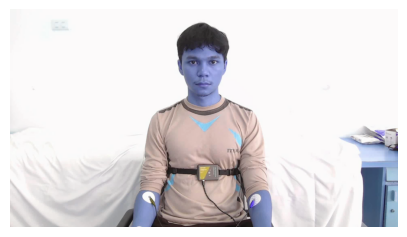

In [5]:
single_img = frames_array[0].copy()
plt.figure(figsize=(5, 5))
plt.imshow(single_img)
plt.axis('off')
plt.show()

Sekarang kita akan mengubah warna gambar dari BGR (Blue Green Red) menjadi RGB (Red Green Blue). 

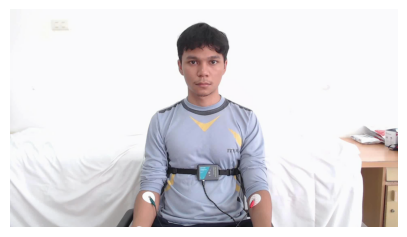

In [6]:
single_img = cv2.cvtColor(single_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(single_img)
plt.axis('off')
plt.show()

### Melakukan deteksi wajah dengan menggunakan library `dlib`.

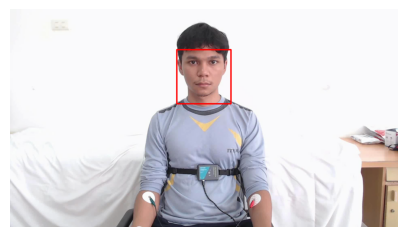

In [7]:
detector = dlib.get_frontal_face_detector()

faces = detector(single_img, 1)
for i, face in enumerate(faces): # untuk setiap wajah yang terdeteksi (bisa saja lebih dari satu)
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    x2 = x + w
    y2 = y + h
    cv2.rectangle(single_img, (x, y), (x2, y2), (255, 0, 0), 5)

plt.figure(figsize=(5, 5))
plt.imshow(single_img)
plt.axis('off')
plt.show()

#### Penjelasan terkait kode di atas:
```python
faces = detector(single_img, 1)
```
- **`detector(single_img, 1)`**: Ini menggunakan `dlib` face detector (`detector`), yang akan mendeteksi wajah pada gambar `single_img`.
  - `single_img`: Ini adalah gambar input yang ingin dideteksi wajahnya.
  - `1`: Ini adalah parameter opsional yang menentukan jumlah piramida gambar yang digunakan oleh algoritma deteksi wajah. Nilai `1` berarti algoritma akan menggunakan piramida untuk mencari wajah dalam berbagai ukuran.
- **`faces`**: Variabel ini menyimpan hasil deteksi wajah. Ini adalah sebuah list yang berisi objek bounding box untuk setiap wajah yang ditemukan pada gambar. Jika ada lebih dari satu wajah, `faces` akan berisi beberapa item.

```python
for i, face in enumerate(faces):
```
- **`for i, face in enumerate(faces)`**: Ini adalah loop yang akan berjalan sebanyak jumlah wajah yang terdeteksi.
  - **`enumerate(faces)`**: `enumerate` memberikan dua nilai untuk setiap iterasi loop: 
    - `i`: Indeks dari wajah yang terdeteksi (dimulai dari 0).
    - `face`: Objek bounding box dari setiap wajah yang terdeteksi. Objek ini memiliki koordinat posisi wajah dalam gambar.

```python
x, y, w, h = face.left(), face.top(), face.width(), face.height()
```
- **`face.left()`**: Mengambil koordinat x dari tepi kiri kotak pembatas (bounding box) wajah.
- **`face.top()`**: Mengambil koordinat y dari tepi atas kotak pembatas wajah.
- **`face.width()`**: Mengambil lebar bounding box wajah.
- **`face.height()`**: Mengambil tinggi bounding box wajah.
- **`x, y, w, h`**: Variabel ini menyimpan posisi dan ukuran dari bounding box wajah yang terdeteksi, di mana:
  - `x`: Koordinat x dari sudut kiri atas wajah.
  - `y`: Koordinat y dari sudut kiri atas wajah.
  - `w`: Lebar bounding box wajah.
  - `h`: Tinggi bounding box wajah.

```python
x2 = x + w
```
- **`x2 = x + w`**: Menghitung koordinat x dari sudut kanan bawah bounding box. Ini didapat dengan menjumlahkan nilai `x` (koordinat kiri atas) dengan `w` (lebar bounding box).

```python
y2 = y + h
```
- **`y2 = y + h`**: Menghitung koordinat y dari sudut kanan bawah bounding box. Ini didapat dengan menjumlahkan nilai `y` (koordinat kiri atas) dengan `h` (tinggi bounding box).

```python
cv2.rectangle(single_img, (x, y), (x2, y2), (255, 0, 0), 5)
```
- **`cv2.rectangle(single_img, (x, y), (x2, y2), (255, 0, 0), 5)`**:
  - Ini menggunakan OpenCV (`cv2`) untuk menggambar kotak persegi panjang (bounding box) di sekitar wajah yang terdeteksi.
  - **`single_img`**: Gambar tempat kotak akan digambar.
  - **`(x, y)`**: Titik sudut kiri atas dari bounding box (posisi awal persegi).
  - **`(x2, y2)`**: Titik sudut kanan bawah dari bounding box (posisi akhir persegi).
  - **`(255, 0, 0)`**: Warna persegi panjang dalam format BGR (Biru, Hijau, Merah), di mana (255, 0, 0) berarti biru.
  - **`5`**: Ketebalan garis persegi panjang.

Jadi, baris ini menggambar kotak biru dengan ketebalan garis 5 pixel di sekitar wajah yang terdeteksi pada gambar.

### Mendeteksi Wajah pada Video

In [2]:
VID_PATH = os.path.join(os.getcwd(), 'media', 'toby-rgb.mp4')
OUTPUT_PATH = os.path.join(os.getcwd(), 'media', 'toby-rgb-roi.mp4')
detector = dlib.get_frontal_face_detector()

cap = cv2.VideoCapture(VID_PATH)
fps = 30 

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'h264')  # Codec for mp4
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (frame_width, frame_height))

total_frame_diproses = fps * 5 # 5 detik
frame_count = 0

start_time = dt.datetime.now()

while frame_count < total_frame_diproses:
    ret, frame = cap.read()
    if not ret:
        break
    
    ### PROSES SETIAP FRAME DISINI ###
    faces = detector(frame, 1)
    for i, face in enumerate(faces): # untuk setiap wajah yang terdeteksi (bisa saja lebih dari satu)
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    ### AKHIR DARI PEMROSESAN TIAP FRAME ###
    
    # cv2.imshow('Video', frame) # dikarenakan bug di MacOS, saya tidak menampilkan window videonya
    out.write(frame)
    
    frame_count += 1
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

print(f"Waktu yang diperlukan: {dt.datetime.now() - start_time}")

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


Waktu yang diperlukan: 0:01:14.810365


### Melakukan Facial Tracking

In [ ]:
VID_PATH = os.path.join(os.getcwd(), 'media', 'toby-rgb.mp4')
OUTPUT_PATH = os.path.join(os.getcwd(), 'media', 'toby-rgb-roi-tracking.mp4')
detector = dlib.get_frontal_face_detector()

cap = cv2.VideoCapture(VID_PATH)
fps = 30

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (frame_width, frame_height))

total_frame_diproses = fps * 10  # 10 seconds
frame_count = 0

start_time = dt.datetime.now()

face_detected = False
p0 = None  # Initial points for tracking
lk_params = dict(winSize=(50, 50), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Variables to periodically re-detect the face
detection_interval = fps * 3  # Re-detect the face every 3 seconds
detection_countdown = detection_interval

while frame_count < total_frame_diproses:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if frame_count == 0 or detection_countdown == 0:  # First frame or re-detection
        faces = detector(gray, 1)
        if faces:
            # Take the first detected face
            face = faces[0]
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Get the initial tracking points
            face_roi = gray[y:y + h, x:x + w]
            p0 = cv2.goodFeaturesToTrack(face_roi, mask=None, maxCorners=10, qualityLevel=0.8, minDistance=10, blockSize=10)
            if p0 is not None:
                p0[:, :, 0] += x
                p0[:, :, 1] += y

            face_detected = True
            detection_countdown = detection_interval  # Reset countdown for re-detection
    else:  # Track the face in subsequent frames
        if face_detected and p0 is not None:
            # Perform optical flow tracking
            p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, gray, p0, None, **lk_params)
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # Calculate the shift using median to avoid outliers
            if len(good_new) > 0:
                x_shift = np.median(good_new[:, 0] - good_old[:, 0])
                y_shift = np.median(good_new[:, 1] - good_old[:, 1])

                x = int(x + x_shift)
                y = int(y + y_shift)

                # Ensure the bounding box remains within the frame boundaries
                x = max(0, min(x, frame_width - w))
                y = max(0, min(y, frame_height - h))

                # Draw the rectangle around the tracked face
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Update the tracking points
            p0 = good_new.reshape(-1, 1, 2)

    # Write the processed frame to the output
    out.write(frame)

    # Update the previous frame for optical flow in the next iteration
    prev_gray = gray.copy()

    frame_count += 1
    detection_countdown -= 1  # Decrease countdown for re-detection
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Waktu yang diperlukan: {dt.datetime.now() - start_time}")
